Доступ к гугл диску

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Доступ к файлу и импорт таблицы

In [3]:
import pandas as pd
import numpy as np

file_path = '/content/drive/MyDrive/ММЭ/я/FRA_NIOT_nov16.xlsx'

xls = pd.ExcelFile(file_path)
df_io = pd.read_excel(xls, sheet_name='National IO-tables')

df_io.head()

,Year,Code,Description,Origin,A01,A02,A03,B,C10-C12,C13-C15,...,R_S,T,U,CONS_h,CONS_np,CONS_g,GFCF,INVEN,EXP,GO
0,NaN,NaN,NaN,NaN,"Crop and animal production, hunting and relate...",Forestry and logging,Fishing and aquaculture,Mining and quarrying,"Manufacture of food products, beverages and to...","Manufacture of textiles, wearing apparel and l...",...,Other service activities,Activities of households as employers; undiffe...,Activities of extraterritorial organizations a...,Final consumption expenditure by households,Final consumption expenditure by non-profit or...,Final consumption expenditure by government,Gross fixed capital formation,Changes in inventories and valuables,Exports,Total output
1,2000.0,A01,"Crop and animal production, hunting and relate...",Domestic,11286.9844,101.788429,3.432276,5.163333,25222.847397,243.266731,...,79.215397,0,0,11563.246148,0,4.583363,1138.590382,443.262226,8149.150475,60949.2876
2,2000.0,A02,Forestry and logging,Domestic,0.09854,653.94849,0,0.0002,1.579927,0.001044,...,2.909655,0,0,406.356952,0,0,291.204012,900.827999,186.187882,3683.3168
3,2000.0,A03,Fishing and aquaculture,Domestic,66.131115,4.290916,30.188783,0,1060.305276,13.122687,...,13.019014,0,0,141.361075,0,0,0,-4.816998,386.1591,1849.9708
4,2000.0,B,Mining and quarrying,Domestic,7.09008,0.112457,2.36611,7.984098,32.718677,4.256463,...,1.460092,0,0,0.784069,0,0,0,124.232325,549.141887,4421.2732


данные за 2010 и 2014 год + удаление ненужных столбцов

In [4]:
df_2010 = df_io[df_io['Year'] == 2010]
df_2014 = df_io[df_io['Year'] == 2014]

# словарь дескрипшинов
new_ind_2010 = df_2010['Code'].tolist()
new_ind_2014 = df_2014['Code'].tolist()

df_2010 = df_2010.drop(columns=['Description', 'Year'])
df_2014 = df_2014.drop(columns=['Description', 'Year'])
# Создаём словарь описаний на основе колонки Description
descriptions_2010 = df_io[df_io['Year'] == 2010].set_index('Code')['Description'].to_dict()
descriptions_2014 = df_io[df_io['Year'] == 2014].set_index('Code')['Description'].to_dict()

# df_2010.columns


Функция создания матриц. Удаление нулевых значений и неинформативных столбцов

In [5]:
def create_matrix(df):
    df = df[df['Origin'] == 'Domestic']

    zero_indices = list(df[df['GO'] == 0]['Code'])
    df = df[~df['Code'].isin(zero_indices)]
    df = df.drop(columns=zero_indices, errors='ignore')

    sector_columns = df.columns[2:-8]

    A = df[sector_columns].to_numpy(dtype='float32')
    A = A[:len(sector_columns), :len(sector_columns)]

    # вектор выпуска
    output = df['GO'].to_numpy(dtype='float32')

    # проверка длины вектора
    if len(output) != A.shape[0]:
        output = output[:A.shape[0]]

    A = A / output[:, None]

    return A, sector_columns

In [6]:
m2010, new_ind_2010 = create_matrix(df_2010)
m2014, new_ind_2014 = create_matrix(df_2014)
#new_ind_2010

Функция проверки продуктивности по минорам матрицы

In [7]:
def check_productivity(A):
    D = np.eye(A.shape[0]) - A  # D = I - A

    for i in range(1, D.shape[0] + 1):
        minor = D[:i, :i]  # минор i x i
        if np.linalg.det(minor) <= 0:
            print(f'Minor of {i}-th degree is not positive')
            return False

    print('A is productive')
    return True


In [8]:
check_productivity(m2010)
check_productivity(m2014)

A is productive
A is productive


True

Функция создания словарей спроса

In [9]:
def construct_demands(A):
    d = np.sum(A, axis=1) - np.diag(A)  # Сумма по строкам без диагональных элементов

    # Вычисление косвенного спроса
    AA = A @ A
    dd = np.sum(AA, axis=1) - np.diag(AA)

    d_dict = dict(enumerate(d)) # прямой спрос
    dd_dict = dict(enumerate(dd)) # косвенный спрос

    return [d_dict, dd_dict]

In [10]:
d2010, dd2010 = construct_demands(m2010)
print(f"Макс: {max(dd2010.values())}, Мин: {min(d2010.values())}, Макс: {max(dd2010.values())}, Мини: {min(dd2010.values())}")

d2014, dd2014 = construct_demands(m2014)
print(f"Макс: {max(dd2014.values())}, Мин: {min(d2014.values())}, Макс: {max(dd2014.values())}, Мини: {min(dd2014.values())}")
dd2014

Макс: 0.4788064658641815, Мин: 0.01506072748452425, Макс: 0.4788064658641815, Мини: 0.005148690193891525
Макс: 0.48888346552848816, Мин: 8.584734341523375e-18, Макс: 0.48888346552848816, Мини: 2.1409986105062082e-18


{0: 0.23097995,
 1: 0.22947711,
 2: 0.20380013,
 3: 0.1927697,
 4: 0.09625828,
 5: 2.1409986e-18,
 6: 0.29520974,
 7: 0.23245148,
 8: 0.46077788,
 9: 0.14235237,
 10: 0.12283627,
 11: 0.019226236,
 12: 0.18632056,
 13: 0.2513232,
 14: 0.16793282,
 15: 0.23726591,
 16: 0.00055473647,
 17: 0.05433965,
 18: 0.027467163,
 19: 0.009735832,
 20: 0.0061131064,
 21: 0.02766394,
 22: 0.14654066,
 23: 0.23010518,
 24: 0.21149881,
 25: 0.26446906,
 26: 0.03588658,
 27: 0.04601693,
 28: 0.16566756,
 29: 0.017279763,
 30: 0.20677996,
 31: 0.002246093,
 32: 0.037211347,
 33: 0.3801896,
 34: 0.358586,
 35: 0.10993122,
 36: 0.09955717,
 37: 0.31293282,
 38: 0.26161,
 39: 0.15478636,
 40: 0.34876332,
 41: 0.118519515,
 42: 0.48888347,
 43: 0.09116213,
 44: 0.37233227,
 45: 0.19334358,
 46: 0.009693633,
 47: 0.26453793,
 48: 0.32440758,
 49: 0.33631334,
 50: 0.027159749,
 51: 0.044987157,
 52: 0.0069031413,
 53: 0.062245667}

функция построения графа со свзями


In [11]:
import matplotlib.pyplot as plt
import networkx as nx

def construct_graph_demands(d, A, indices, descriptions, threshold=0.01, n=5, title="Граф"):
    # Проверка, чтобы n был меньше числа узлов
    if n >= A.shape[0]:
        raise ValueError(f'n must be lower than {A.shape[0]}, given {n}')

    edges, nodes = [], []

    # Построение списка рёбер и узлов
    for i in range(A.shape[0]):
        for j in range(A.shape[1]):
            if i != j and A[i][j] >= threshold:
                edges.append((indices[i], indices[j]))
                if indices[i] not in nodes: nodes.append(indices[i])
                if indices[j] not in nodes: nodes.append(indices[j])

    # Проверим, есть ли рёбра и узлы
    if not edges or not nodes:
        print("Нет рёбер или узлов для построения графа.")
        return

    # Вычисление размера узлов на основе спроса
    size_based = 10000
    summ_d = sum(d.values())
    sizes = [(d[i] / summ_d * size_based) for i in range(len(nodes))]

    # Отбор топ-n узлов на основе спроса
    top_n_indices = sorted(d.items(), key=lambda x: x[1], reverse=True)[:n]

    # Построение графа
    g = nx.DiGraph(edges)
    pos = nx.circular_layout(g)

    plt.ion()

    # Отрисовка графа
    nx.draw(g, pos, node_size=sizes, node_color='skyblue', with_labels=False, edge_color='gray', arrowsize=10)
    labels = {node: str(node) for node in nodes}  # Подписи для узлов
    nx.draw_networkx_labels(g, pos, labels=labels, font_size=10, font_color='black', verticalalignment='top')

    plt.title(title, fontsize=14)
    plt.axis("off")
    plt.show()

    print("\nИндекс -> Отрасль")
    for node in nodes:
        print(f"{node} -> {descriptions.get(node, f'Unknown {node}')}")

    top_n = [descriptions.get(i[0], f'Unknown {i[0]}') for i in top_n_indices]

    # Подсчёт связей для каждого узла
    degree_dict = dict(g.degree())
    sorted_degree = sorted(degree_dict.items(), key=lambda x: x[1], reverse=True)

    print("\nТоп-5 отраслей с наибольшими связями:")
    for node, degree in sorted_degree[:5]:
        print(f"{descriptions.get(node, 'Unknown')} (Связи: {degree})")

    print("\nТоп-5 отраслей с наименьшими связями:")
    for node, degree in sorted_degree[-5:]:
        print(f"{descriptions.get(node, 'Unknown')} (Связи: {degree})")

    return top_n  # Возвращаем топ-n узлов


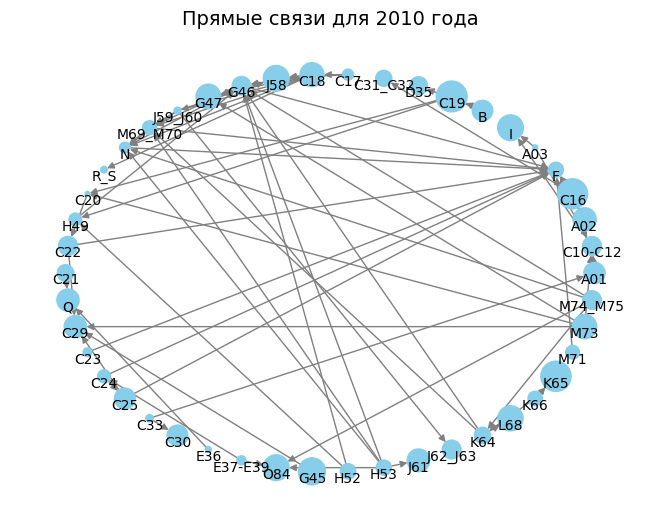


Индекс -> Отрасль
A01 -> Crop and animal production, hunting and related service activities
C10-C12 -> Manufacture of food products, beverages and tobacco products
A02 -> Forestry and logging
C16 -> Manufacture of wood and of products of wood and cork, except furniture; manufacture of articles of straw and plaiting materials
F -> Construction
A03 -> Fishing and aquaculture
I -> Accommodation and food service activities
B -> Mining and quarrying
C19 -> Manufacture of coke and refined petroleum products 
D35 -> Electricity, gas, steam and air conditioning supply
C31_C32 -> Manufacture of furniture; other manufacturing
C17 -> Manufacture of paper and paper products
C18 -> Printing and reproduction of recorded media
J58 -> Publishing activities
G46 -> Wholesale trade, except of motor vehicles and motorcycles
G47 -> Retail trade, except of motor vehicles and motorcycles
J59_J60 -> Motion picture, video and television programme production, sound recording and music publishing activities; pr

In [12]:
threshold = 0.05
n = 10

# Построение графа для прямых связей (прямой спрос) 2010 года
top_n_d2010 = construct_graph_demands(d2010, m2010, new_ind_2010, descriptions_2010, threshold, n, title="Прямые связи для 2010 года")

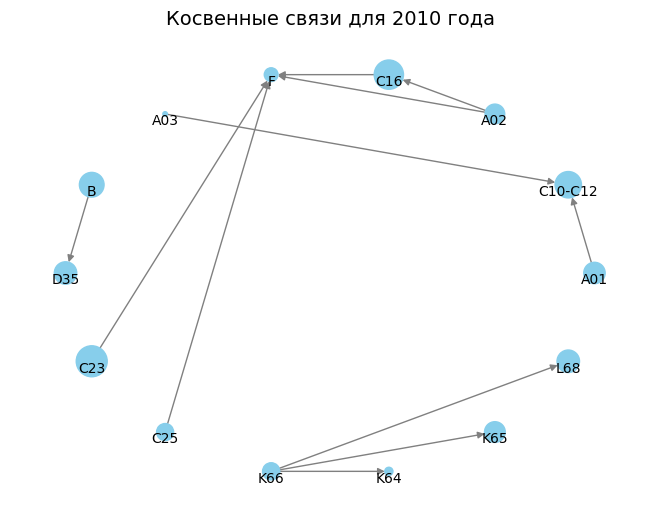


Индекс -> Отрасль
A01 -> Crop and animal production, hunting and related service activities
C10-C12 -> Manufacture of food products, beverages and tobacco products
A02 -> Forestry and logging
C16 -> Manufacture of wood and of products of wood and cork, except furniture; manufacture of articles of straw and plaiting materials
F -> Construction
A03 -> Fishing and aquaculture
B -> Mining and quarrying
D35 -> Electricity, gas, steam and air conditioning supply
C23 -> Manufacture of other non-metallic mineral products
C25 -> Manufacture of fabricated metal products, except machinery and equipment
K66 -> Activities auxiliary to financial services and insurance activities
K64 -> Financial service activities, except insurance and pension funding
K65 -> Insurance, reinsurance and pension funding, except compulsory social security
L68 -> Real estate activities

Топ-5 отраслей с наибольшими связями:
Construction (Связи: 4)
Activities auxiliary to financial services and insurance activities (Связ

In [13]:
# Построение графа для косвенных связей (косвенный спрос) 2010 года
AA_2010 = m2010 @ m2010  # Матрица косвенных связей
top_n_dd2010 = construct_graph_demands(dd2010, AA_2010, new_ind_2010, descriptions_2010, threshold, n, title="Косвенные связи для 2010 года")

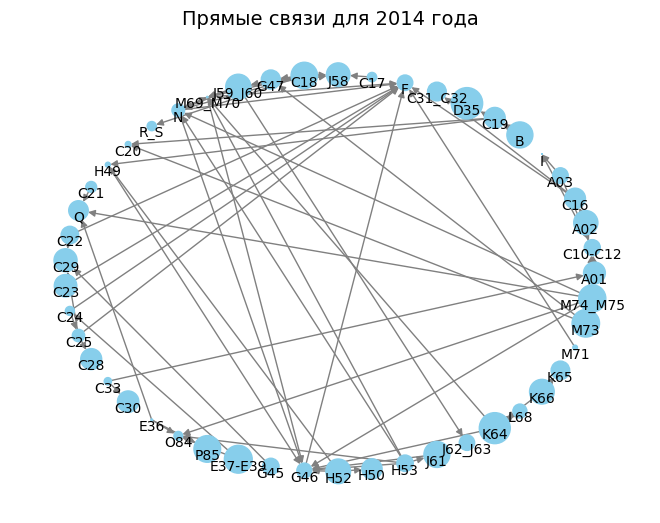


Индекс -> Отрасль
A01 -> Crop and animal production, hunting and related service activities
C10-C12 -> Manufacture of food products, beverages and tobacco products
A02 -> Forestry and logging
C16 -> Manufacture of wood and of products of wood and cork, except furniture; manufacture of articles of straw and plaiting materials
A03 -> Fishing and aquaculture
I -> Accommodation and food service activities
B -> Mining and quarrying
C19 -> Manufacture of coke and refined petroleum products 
D35 -> Electricity, gas, steam and air conditioning supply
C31_C32 -> Manufacture of furniture; other manufacturing
F -> Construction
C17 -> Manufacture of paper and paper products
J58 -> Publishing activities
C18 -> Printing and reproduction of recorded media
G47 -> Retail trade, except of motor vehicles and motorcycles
J59_J60 -> Motion picture, video and television programme production, sound recording and music publishing activities; programming and broadcasting activities
M69_M70 -> Legal and accoun

In [14]:
# Прямые связи для 2014 года
top_n_d2014 = construct_graph_demands(d2014, m2014, new_ind_2014, descriptions_2014, threshold, n, title="Прямые связи для 2014 года")

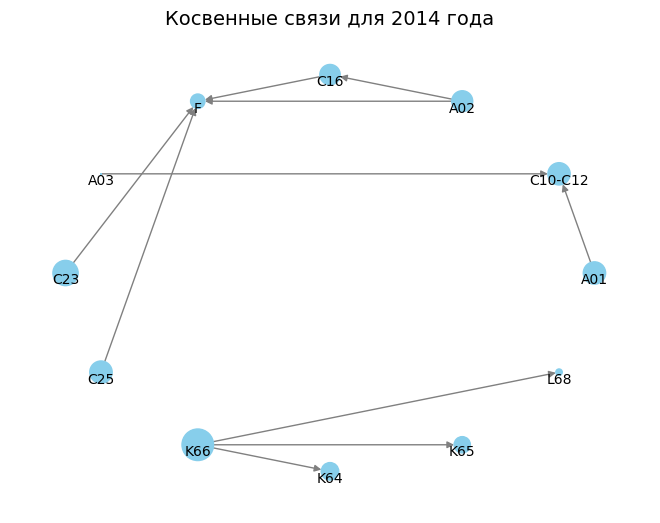


Индекс -> Отрасль
A01 -> Crop and animal production, hunting and related service activities
C10-C12 -> Manufacture of food products, beverages and tobacco products
A02 -> Forestry and logging
C16 -> Manufacture of wood and of products of wood and cork, except furniture; manufacture of articles of straw and plaiting materials
F -> Construction
A03 -> Fishing and aquaculture
C23 -> Manufacture of other non-metallic mineral products
C25 -> Manufacture of fabricated metal products, except machinery and equipment
K66 -> Activities auxiliary to financial services and insurance activities
K64 -> Financial service activities, except insurance and pension funding
K65 -> Insurance, reinsurance and pension funding, except compulsory social security
L68 -> Real estate activities

Топ-5 отраслей с наибольшими связями:
Construction (Связи: 4)
Activities auxiliary to financial services and insurance activities (Связи: 3)
Manufacture of food products, beverages and tobacco products (Связи: 2)
Forestr

In [15]:
# Косвенные связи для 2014 года
AA_2014 = m2014 @ m2014  # Матрица косвенных связей
top_n_dd2014 = construct_graph_demands(dd2014, AA_2014, new_ind_2014, descriptions_2014, threshold, n, title="Косвенные связи для 2014 года")


исключение отраслей

In [16]:
def remove_sectors(demand, matrix, sectors, output):
    # Создаём словарь, где ключ — индекс отрасли, а значение — сумма всех связей (кроме диагональных элементов)
    sector_connections = {i: np.sum(matrix[i]) - matrix[i][i] for i in range(matrix.shape[0])}

    sorted_sectors = sorted(sector_connections.items(), key=lambda x: x[1])

    # с наименьшими связями
    indices_to_remove = [sector[0] for sector in sorted_sectors[:10]]  # Берём первые 10 отраслей

    # Обновляем списки, исключая удалённые отрасли
    updated_sectors = [sector for i, sector in enumerate(sectors) if i not in indices_to_remove]
    updated_output = [out for i, out in enumerate(output) if i not in indices_to_remove]

    # Удаляем строки и столбцы
    updated_matrix = np.delete(matrix, indices_to_remove, axis=0)
    updated_matrix = np.delete(updated_matrix, indices_to_remove, axis=1)

    print("\nУдалённые отрасли с наименьшими связями:")
    for i in indices_to_remove:
        print(f"{sectors[i]} (Связи: {sector_connections[i]})")

    return updated_matrix, updated_sectors, updated_output


In [17]:
updated_matrix_2010, updated_sectors_2010, updated_output_2010 = remove_sectors(d2010, m2010, new_ind_2010, df_2010['GO'].to_numpy())
updated_matrix_2014, updated_sectors_2014, updated_output_2014 = remove_sectors(d2014, m2014, new_ind_2014, df_2014['GO'].to_numpy())

AA_2010 = m2010 @ m2010
updated_matrix_2010_secondary, updated_sectors_2010_secondary, updated_output_2010_secondary = remove_sectors(dd2010, AA_2010, new_ind_2010, df_2010['GO'].to_numpy())

AA_2014 = m2014 @ m2014
updated_matrix_2014_secondary, updated_sectors_2014_secondary, updated_output_2014_secondary = remove_sectors(dd2014, AA_2014, new_ind_2014, df_2014['GO'].to_numpy())



Удалённые отрасли с наименьшими связями:
Q (Связи: 0.01506072748452425)
M72 (Связи: 0.022585060447454453)
C30 (Связи: 0.022759325802326202)
C13-C15 (Связи: 0.02884775400161743)
H50 (Связи: 0.03689483180642128)
C29 (Связи: 0.04414737597107887)
C26 (Связи: 0.04814868047833443)
G47 (Связи: 0.05603575333952904)
O84 (Связи: 0.05799992009997368)
F (Связи: 0.07815074920654297)

Удалённые отрасли с наименьшими связями:
C13-C15 (Связи: 8.584734341523375e-18)
C26 (Связи: 0.0019087493419647217)
H50 (Связи: 0.0036454503424465656)
Q (Связи: 0.015923308208584785)
M72 (Связи: 0.021006561815738678)
C30 (Связи: 0.024924486875534058)
C29 (Связи: 0.03226345032453537)
G47 (Связи: 0.05236434191465378)
O84 (Связи: 0.05792742222547531)
H51 (Связи: 0.07370467483997345)

Удалённые отрасли с наименьшими связями:
C30 (Связи: 0.005148690193891525)
Q (Связи: 0.0065313177183270454)
C13-C15 (Связи: 0.010165358893573284)
M72 (Связи: 0.01061500795185566)
C29 (Связи: 0.014402139000594616)
C26 (Связи: 0.015028516761958

Функция агрегации для группирования отраслей

In [18]:
def aggregate_sectors(x_d, matr, descr, ag1, ag2, ag3, ag4, ag5, descriptions):
    descr = list(descr)

    # функция для получения индексов отраслей
    def get_indices(descr, ag):
        return [descr.index(sector) for sector in ag if sector in descr]

    # Получаем индексы для каждой группы отраслей
    idx1 = get_indices(descr, ag1)
    idx2 = get_indices(descr, ag2)
    idx3 = get_indices(descr, ag3)
    idx4 = get_indices(descr, ag4)
    idx5 = get_indices(descr, ag5)

    # Создаем пустую матрицу 5x5 для агрегированных данных
    Agr = np.zeros((5, 5))
    all_groups = [idx1, idx2, idx3, idx4, idx5]

    # Заполнение агрегированной матрицы
    for i, group_i in enumerate(all_groups):
        for j, group_j in enumerate(all_groups):
            total_sum = 0  # Переменная для нормализации
            for m in group_i:
                for n in group_j:
                    Agr[i, j] += matr[m, n] * x_d[n]  # Суммируем значение с учетом выпуска
                    total_sum += x_d[n]
            if total_sum != 0:
                Agr[i, j] /= total_sum

    # Вывод названий групп для интерпретации
    # print("\nНазвания отраслей по группам:")
    # for i, group in enumerate(all_groups):
    #    print(f"Группа {i+1}: {[descriptions.get(descr[j], 'Unknown') for j in group]}")

    return Agr


In [19]:
# Три различных случая агрегации для Франции (2010 и 2014)

def aggregate_case_1(x_d, matr, descr, descriptions):
    fr_ag1 = ["C24", "C29", "G46", "C20"]
    fr_ag2 = ["K64", "K66", "L68"]
    fr_ag3 = ["O84", "P85", "Q"]
    fr_ag4 = ["F", "D35", "E36"]
    fr_ag5 = ["H49", "H50", "H51"]
    return aggregate_sectors(x_d, matr, descr, fr_ag1, fr_ag2, fr_ag3, fr_ag4, fr_ag5, descriptions)

def aggregate_case_2(x_d, matr, descr, descriptions):
    fr_ag1 = ["C24", "C29", "G46", "C20", "C22"]
    fr_ag2 = ["K64", "K65", "L68"]
    fr_ag3 = ["O84", "P85", "Q", "J61"]
    fr_ag4 = ["F", "D35", "E36", "E37-E39"]
    fr_ag5 = ["H49", "H50", "H51", "I"]
    return aggregate_sectors(x_d, matr, descr, fr_ag1, fr_ag2, fr_ag3, fr_ag4, fr_ag5, descriptions)

def aggregate_case_3(x_d, matr, descr, descriptions):
    fr_ag1 = ["C24", "G46", "C20"]
    fr_ag2 = ["K64", "K66"]
    fr_ag3 = ["O84", "P85"]
    fr_ag4 = ["F", "D35"]
    fr_ag5 = ["H49", "H51"]
    return aggregate_sectors(x_d, matr, descr, fr_ag1, fr_ag2, fr_ag3, fr_ag4, fr_ag5, descriptions)

Применение к данным 2010 и 2014 годов

In [20]:
Agr_2010_case1 = aggregate_case_1(df_2010['GO'].to_numpy(), m2010, new_ind_2010, descriptions_2010)
Agr_2014_case1 = aggregate_case_1(df_2014['GO'].to_numpy(), m2014, new_ind_2014, descriptions_2014)

Agr_2010_case2 = aggregate_case_2(df_2010['GO'].to_numpy(), m2010, new_ind_2010, descriptions_2010)
Agr_2014_case2 = aggregate_case_2(df_2014['GO'].to_numpy(), m2014, new_ind_2014, descriptions_2014)

Agr_2010_case3 = aggregate_case_3(df_2010['GO'].to_numpy(), m2010, new_ind_2010, descriptions_2010)
Agr_2014_case3 = aggregate_case_3(df_2014['GO'].to_numpy(), m2014, new_ind_2014, descriptions_2014)

print("Агрегированная матрица Франции 2010 года (случай 1):")
print(Agr_2010_case1)
print("\nАгрегированная матрица Франции 2010 года (случай 2):")
print(Agr_2010_case2)
print("\nАгрегированная матрица Франции 2010 года (случай 3):")
print(Agr_2010_case3)

Агрегированная матрица Франции 2010 года (случай 1):
[[0.02353628 0.00145094 0.00355566 0.02685932 0.00142524]
 [0.01906203 0.08681208 0.00813525 0.01126448 0.00547419]
 [0.00260884 0.00128816 0.00515505 0.00256872 0.00189726]
 [0.00946747 0.00503287 0.02456471 0.07910107 0.00244152]
 [0.02809955 0.00139195 0.00762764 0.0061593  0.0359138 ]]

Агрегированная матрица Франции 2010 года (случай 2):
[[0.02483119 0.00134743 0.00327633 0.03405836 0.00387862]
 [0.01994512 0.06233702 0.00941518 0.01027945 0.0062829 ]
 [0.00821493 0.00496347 0.01077406 0.00369118 0.00201746]
 [0.01129221 0.00662762 0.02405402 0.06435039 0.00446715]
 [0.024986   0.00209779 0.00793138 0.00516331 0.01997748]]

Агрегированная матрица Франции 2010 года (случай 3):
[[0.02896307 0.00044277 0.0022806  0.03659004 0.00168816]
 [0.02124365 0.17694189 0.009472   0.01614481 0.00772413]
 [0.00401812 0.00237254 0.00472491 0.0035394  0.00309047]
 [0.00790414 0.00149483 0.01144439 0.11184655 0.00368282]
 [0.04967716 0.00399702 0

In [21]:
print("\nАгрегированная матрица Франции 2014 года (случай 1):")
print(Agr_2014_case1)
print("\nАгрегированная матрица Франции 2014 года (случай 2):")
print(Agr_2014_case2)
print("\nАгрегированная матрица Франции 2014 года (случай 3):")
print(Agr_2014_case3)


Агрегированная матрица Франции 2014 года (случай 1):
[[0.02027171 0.001449   0.00361202 0.02615528 0.00124557]
 [0.02041484 0.08672085 0.00764244 0.01221559 0.00603224]
 [0.00284712 0.00131524 0.00592651 0.00264007 0.0019342 ]
 [0.0098684  0.00555162 0.02695218 0.07829738 0.00256927]
 [0.02953981 0.00121234 0.00745277 0.00543488 0.0297033 ]]

Агрегированная матрица Франции 2014 года (случай 2):
[[0.02147653 0.00133799 0.00329335 0.03218488 0.00366358]
 [0.02114687 0.06520169 0.00907006 0.01033736 0.00620481]
 [0.00925213 0.00527123 0.01070758 0.00381696 0.00208413]
 [0.01126544 0.00713477 0.02564145 0.06375985 0.0044597 ]
 [0.02666581 0.00207023 0.00809013 0.00467933 0.01620427]]

Агрегированная матрица Франции 2014 года (случай 3):
[[0.02581422 0.00043678 0.00218421 0.03562102 0.00152712]
 [0.02310453 0.16906567 0.00904567 0.0176578  0.00878012]
 [0.00435262 0.00230748 0.00495427 0.00362542 0.00315532]
 [0.00854342 0.001517   0.01158714 0.11148384 0.00396165]
 [0.0513882  0.00336517 

Сравнение агрегированных матриц между случаями и годами:

*   Случай 1 (стандартная агрегация): Матрицы для 2010 и 2014 годов показывают устойчивую структуру взаимосвязей между крупными секторами (промышленность, финансы, строительство), с сильными внутренними связями. Это указывает на стабильность этих отраслей, которые взаимно поддерживают экономику.
*   Случай 2 (расширенная агрегация): Здесь наблюдается больше взаимодействий между секторами, особенно в финансовом и промышленном секторах. Сектора стали более связаны друг с другом, что может поддерживать рост.
*   Случай 3 (с удалением некоторых отраслей): Эти матрицы показывают меньшее количество связей, так как некоторые отрасли исключены. Это позволяет увидеть, как удаление влияет на оставшиеся сектора. Несмотря на изменения, финансы и промышленность остаются ключевыми.

In [22]:
# Определение степенного метода для поиска числа и вектора Фробениуса-Перрона
def Power_Meth(matr, x0, eps, max_iter):
    y_prev = x0
    lam_prev = 0
    for i in range(max_iter):
        y = matr @ y_prev
        lam = (y.T @ y_prev) / (y_prev.T @ y_prev)
        if np.abs(lam - lam_prev) < eps:
            break
        y_prev = y
        lam_prev = lam
    return lam, y

In [23]:
x0 = np.ones(len(Agr_2010_case1[0])).T

# Франция 2010
lam_2010_case1, y_2010_case1 = Power_Meth(Agr_2010_case1, x0, 1e-6, 100)
lam_2010_case2, y_2010_case2 = Power_Meth(Agr_2010_case2, x0, 1e-6, 100)
lam_2010_case3, y_2010_case3 = Power_Meth(Agr_2010_case3, x0, 1e-6, 100)

# Франция 2014
lam_2014_case1, y_2014_case1 = Power_Meth(Agr_2014_case1, x0, 1e-6, 100)
lam_2014_case2, y_2014_case2 = Power_Meth(Agr_2014_case2, x0, 1e-6, 100)
lam_2014_case3, y_2014_case3 = Power_Meth(Agr_2014_case3, x0, 1e-6, 100)

In [24]:
print("Число и вектор Фробениуса-Перрона (случай 1):", lam_2010_case1, y_2010_case1)
print("Число и вектор Фробениуса-Перрона (случай 2):", lam_2010_case2, y_2010_case2)
print("Число и вектор Фробениуса-Перрона (случай 3):", lam_2010_case3, y_2010_case3)

Число и вектор Фробениуса-Перрона (случай 1): 0.09683718668006316 [1.51873975e-31 7.87503009e-31 2.81635145e-32 3.61353986e-31
 1.28120150e-31]
Число и вектор Фробениуса-Перрона (случай 2): 0.08562980720624067 [6.60713259e-18 1.23125768e-17 2.17426941e-18 1.06412947e-17
 4.00774365e-18]
Число и вектор Фробениуса-Перрона (случай 3): 0.17810089544499158 [1.06055254e-19 9.86483922e-18 1.50556109e-19 2.84349865e-19
 4.09011900e-19]


In [25]:
print("Число и вектор Фробениуса-Перрона (случай 1):", lam_2014_case1, y_2014_case1)
print("Число и вектор Фробениуса-Перрона (случай 2):", lam_2014_case2, y_2014_case2)
print("Число и вектор Фробениуса-Перрона (случай 3):", lam_2014_case3, y_2014_case3)

Число и вектор Фробениуса-Перрона (случай 1): 0.09711179187434098 [1.59155041e-30 8.86976045e-30 3.21724524e-31 4.08126094e-30
 1.22174615e-30]
Число и вектор Фробениуса-Перрона (случай 2): 0.08603387839425744 [5.39598898e-19 1.22040454e-18 2.10129735e-19 9.72277911e-19
 3.31754374e-19]
Число и вектор Фробениуса-Перрона (случай 3): 0.17039210535918148 [1.31796267e-21 1.11578109e-19 1.75113789e-21 3.69276382e-21
 4.15176934e-21]


Рассчитываем число и вектор Фробениуса-Перрона для исходной матрицы 2010 и 2014 года

In [26]:
x0_orig = np.ones(len(m2010[0])).T
lam_orig_2010, y_orig_2010 = Power_Meth(m2010, x0_orig, 1e-6, 100)

x0_orig = np.ones(len(m2014[0])).T
lam_orig_2014, y_orig_2014 = Power_Meth(m2014, x0_orig, 1e-6, 100)

print("Число и вектор Фробениуса-Перрона для исходной таблицы 2010 года:", lam_orig_2010)
print(y_orig_2010)
print("\nЧисло и вектор Фробениуса-Перрона для исходной таблицы 2014 года:", lam_orig_2014)
print(y_orig_2014)


Число и вектор Фробениуса-Перрона для исходной таблицы 2010 года: 0.447542800738676
[8.87647612e-18 2.22022115e-17 7.90046094e-18 5.41837367e-17
 5.32563156e-18 4.85761474e-19 1.18812307e-17 1.52702187e-17
 2.94901798e-17 8.15096433e-18 1.05829041e-17 1.25517828e-18
 9.87130190e-18 1.08319714e-17 6.45363316e-18 1.07935614e-17
 8.16472425e-19 3.94468461e-18 2.25429333e-18 6.84487241e-19
 1.83599875e-19 1.86026560e-18 5.91682022e-18 7.39295502e-17
 1.26472244e-17 1.72107363e-17 3.05308229e-18 2.58980807e-18
 9.08303688e-18 9.38940903e-19 1.18790132e-17 1.60676601e-18
 2.61886341e-18 2.16589473e-17 2.29007648e-17 6.06478992e-18
 6.85407056e-18 1.78259821e-17 1.77947737e-17 1.07738630e-17
 2.16951009e-17 7.01623582e-18 2.98635026e-17 5.53416890e-18
 2.67169836e-17 1.40376212e-17 6.04990540e-19 1.56458530e-17
 1.76451656e-17 2.18573593e-17 1.66465545e-18 2.67447486e-18
 3.83660440e-19 4.15285816e-18]

Число и вектор Фробениуса-Перрона для исходной таблицы 2014 года: 0.43205873351012136
[1.7

1. Анализ числа Фробениуса-Перрона

*   Для 2010 года: Число Фробениуса-Перрона (случай 1): 0.0968 — высокий показатель устойчивости между стандартными секторами.
Число Фробениуса-Перрона (случай 2): 0.0856 — уменьшение связи между секторами, что связано с расширенной агрегацией.
Число Фробениуса-Перрона (случай 3): 0.1781 — самое высокое значение, что отражает доминирование оставшихся отраслей и концентрацию внутренних связей.

*   Для 2014 года:
Число Фробениуса-Перрона (случай 1): 0.0971 — стабильный рост взаимосвязей по сравнению с 2010 годом.
Число Фробениуса-Перрона (случай 2): 0.0860 — указывает на усиление взаимодействий, как и в 2010 году.
Число Фробениуса-Перрона (случай 3): 0.1704 — снижение, указывающее на несколько более слабые внутренние связи среди оставшихся отраслей.

2. Анализ собственных векторов Фробениуса-Перрона


*   Вектор показывает, что финансовый и промышленный секторы являются основными, оказывая значительное влияние на структуру экономики.
Сравнение собственных векторов между 2010 и 2014 годами указывает на устойчивость роли этих секторов, особенно в случае 1. В 2014 году значения немного выше, что предполагает улучшение взаимодействий между крупными группами.

3. Агрегация снижает изначальное число Фробениуса-Перрона, так как сокращает детализацию и количество межотраслевых связей. В исходной матрице значение выше, что отражает более тесные связи между всеми отраслями, включая мелкие.